In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

In [2]:
#crate paths for csv files
CURR_DIR = os.getcwd()
print(CURR_DIR)
zlecenia_path = os.path.join(CURR_DIR, 'Zlecenia.csv')
godziny_path = os.path.join(CURR_DIR, 'Godziny.csv')
New_Precalc_path = os.path.join(CURR_DIR, 'New_Precalc.csv')

C:\Users\ksobo\Desktop\DS_final_project


In [3]:
#Zaciagniecie baz danych
obciazenie_df = pd.read_csv(zlecenia_path, sep=';')
godziny_df = pd.read_csv(godziny_path, sep=';')
New_Precalc_df = pd.read_csv(New_Precalc_path, sep=';')

In [4]:
#Ekstrakcja danych i organizacja danych - pozostawienie tylko kolumn wymaganych, pozostawienie tylko projektów "w toku"
obciazenie_df1 = obciazenie_df.drop(columns=['work_preparation_Plan','work_preparation_done'], axis=1)
obciazenie_df2 = obciazenie_df1.loc[obciazenie_df1['Active'].isin(['Active'])]
godziny_df = godziny_df[['No','Wszystkie.technol','Wszystkie.wykonane']]

In [5]:
#Left join po No z godzinami
obciazenie_df2 = pd.merge(obciazenie_df2, godziny_df, how='left', on='No')


#wypelnienie NaN zerami
obciazenie_df2['Wszystkie.technol'] = obciazenie_df2['Wszystkie.technol'].fillna(0)
obciazenie_df2['Wszystkie.wykonane'] = obciazenie_df2['Wszystkie.wykonane'].fillna(0)

In [6]:
#Zdefiniowanie tygodnia obecnego przyjmujemy obecny jako 202112 - tydzień zaciągnięcia danych z baz,
current_week = 202112

In [7]:
#docelowo może zostać zamieniony funkcją obliczającą jak poniżej
#today = datetime.date.today()
#year = today.isocalendar()[0]
#wk = today.isocalendar()[1]
#current_week = int(str(year) + str(wk))
#current_week

In [8]:
#Zmiana terminu rozpoczęcia oraz zakończenia na obecny jeżeli miało mieć ono miejsce w przeszłości
obciazenie_df2.loc[obciazenie_df2['Finnish_week'] < current_week, 'Finnish_week'] = current_week

obciazenie_df2.loc[obciazenie_df2['Pre_fabrication_plan'] < current_week, 'Pre_fabrication_plan'] = current_week

In [9]:
#Zlecenia które nie zostały opracowane wypełnione zostaną wartościami przewidzianymi w prekalkulacji

#A - dziób(wędka)
#Labor rate	130 rbg/1000kg
#Assembling	0,4
#Welding	0,33
#Grindining	0,07
#Else		0,2

#B - belka(środek)
#Labor rate	100 rbg/1000kg
#Assembling	0,3
#Welding	0,4
#Grindining	0,2
#Else		0,1

#C - gniazdo(końcówka)
#Labor rate	120 rbg/1000kg
#Assembling	0,25
#Welding	0,4
#Grindining	0,2
#Else		0,15

obciazenie_df2.loc[obciazenie_df2['Typ'] == 'A', 'Typ'] = 0.13
obciazenie_df2.loc[obciazenie_df2['Typ'] == 'B', 'Typ'] = 0.1
obciazenie_df2.loc[obciazenie_df2['Typ'] == 'C', 'Typ'] = 0.12

# IF Wszystkie technol = NaN -> Weight for 1 * Quantity * Typ

obciazenie_df2.loc[obciazenie_df2['Wszystkie.technol'] == 0, 'Wszystkie.technol'] = obciazenie_df2['Weight_for_1'] * obciazenie_df2['Quantity'] * obciazenie_df2['Typ']

In [10]:
#Obliczenie kolumn - pozostałego czasu na produkcję oraz pozostałych godzin
obciazenie_df2['Weeks_left'] = (obciazenie_df2['Finnish_week']) - (obciazenie_df2['Pre_fabrication_plan'])

#Jeżeli >52 to należy odjąc od wyniku 48 (100 - (ilość tyg w danym roku - def 52))
#Może tak się stać dla projektów na przełomie roku 202206-202146 = 60!
obciazenie_df2.loc[obciazenie_df2['Weeks_left'] > 52, 'Weeks_left'] = obciazenie_df2['Weeks_left'] - 48

#Jeżeli zlecenie jest opóźnione i wynik pozostałego czasu będzie wynosił 0
#to zostanie on doliczony do obecnego tygodnia
obciazenie_df2.loc[obciazenie_df2['Weeks_left'] < 1, 'Weeks_left'] = 1

#funkcja if niestety nie znalazła odpowiedniego zastosowania - loc jest polecany jako dobra praktyka

In [11]:
#Wyliczenie pozostałych godzin pracy
obciazenie_df2['Work_h_left'] = (obciazenie_df2['Wszystkie.technol']) - (obciazenie_df2['Wszystkie.wykonane'])

#Jeżeli zlecenie przekroczyło godziny praca liczona jest w nadgodzinach - przyjmuje się 0 do obciażenia
obciazenie_df2.loc[obciazenie_df2['Work_h_left'] < 0, 'Work_h_left'] = 0

In [12]:
#Podzielenie pozostałej pracy równomiernie na tygodnie i dodanie do dt
obciazenie_df2['Workload_per_week'] = (obciazenie_df2['Work_h_left']) / (obciazenie_df2['Weeks_left'])
obciazenie_df2['Workload_per_week'].astype(int)

0      0
1      0
2      0
3      7
4     64
      ..
58    40
59    80
60    64
61    80
62    80
Name: Workload_per_week, Length: 63, dtype: int32

In [13]:
#Dodanie obciazenia zarezerwowanego na dany tydzien w zależności od rozpoczecia i zakonczenia danego zlecenia.
#Wykorzystanie zmiennej current_week_loop w funkcji if - aby w tygodniach na przełomie roku pokazywała poprawne oznaczenia tygodni.

for i in range (0,13):
    current_week_loop = current_week+i
    conditions = [
        (obciazenie_df2['Pre_fabrication_plan'] <= current_week_loop) & (obciazenie_df2['Finnish_week'] >= current_week_loop),
        (obciazenie_df2['Pre_fabrication_plan'] > current_week_loop) & (obciazenie_df2['Finnish_week'] < current_week_loop)]
    choices = [1, 0]
    
    if current_week_loop > 202153 :
        current_week_loop += 48
    else :
        current_week_loop
        
    obciazenie_df2[current_week_loop] = np.select(conditions, choices, default='0') 

In [14]:
#Wykonanie tabeli z ostatecznymi wynikami
obciazenie_df3 = obciazenie_df2.iloc[: ,-14:].astype(int)
obciazenie_result = obciazenie_df3.iloc[: ,-13:].multiply(obciazenie_df3['Workload_per_week'], axis="index")
obciazenie_result_df = pd.DataFrame({'Required Manpower': obciazenie_result.sum(axis=0)}).astype(int)

,Workload_per_week,202112,202113,202114,202115,202116,202117,202118,202119,202120,202121,202122,202123,202124
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,7,1,1,1,1,1,1,1,1,1,1,1,1,1
4,64,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,40,0,0,0,0,0,0,0,0,0,0,0,0,0
59,80,0,0,0,0,0,0,0,0,0,0,0,0,0
60,64,0,0,0,0,0,0,0,0,0,0,0,0,0
61,80,0,0,0,0,0,0,0,0,0,0,0,0,0


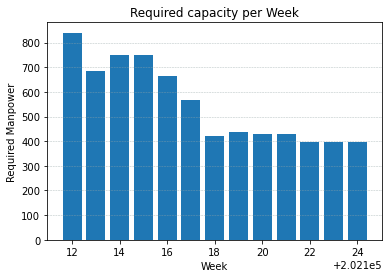

In [15]:
#Wykres plotly
obciazenie_result_df['Week'] = obciazenie_result_df.index
plt.bar(obciazenie_result_df['Week'], obciazenie_result_df['Required Manpower'])
plt.xlabel('Week')
plt.ylabel('Required Manpower')
plt.title('Required capacity per Week')
plt.grid(color='#95a5a6', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)
plt.xscale('linear')

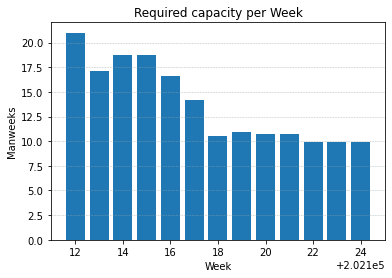

In [16]:
#W celu ułatwienia analiz obciążenia wielu pracodawców stosuje w obliczeniach jednostkę Manweek = 40 rbg / tydzień
obciazenie_result_df['Manweeks'] = obciazenie_result_df['Required Manpower']/40
obciazenie_result_df['Week'] = obciazenie_result_df.index
plt.bar(obciazenie_result_df['Week'], obciazenie_result_df['Manweeks'])
plt.xlabel('Week')
plt.ylabel('Manweeks')
plt.title('Required capacity per Week')
plt.grid(color='#95a5a6', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)
plt.xscale('linear')